# Fast.AI
Notes and example code on using fast.ai.

Best place to find information is in the docs!
https://docs.fast.ai/

FastAI can deal with:
- images
- text
- tabular data


# Chapter 1 - Intro

In [1]:
from fastai.vision.all import *
from fastai.text.all import *
from fastai.tabular.all import *


In [ ]:
# Cat/Dog example

path = untar_data(URLs.PETS)/'images'

# Callback to deal with the incoming pictures of cats and dogs
# Files that start with an upper-case letter are pictures of cats
def is_cat(x): 
    return x[0].isupper()

# Dataloader - important bit is the valid_pct - which tells fastai to hold 20% for validation (not included in training)
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

# Create CNN using resnet34 model
# The 34 in resnet34 refers to the number of layers in this variant of the architecture (other options are 18, 50, 101, and 152). 
# A metric is a function that measures the quality of the model's predictions using the validation set, and will be printed at 
# the end of each epoch. In this case, we're using error_rate, which is a function provided by fastai that does just what it 
# says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for 
# classification is accuracy (which is just 1.0 - error_rate). fastai provides many more,
learn = vision_learner(dls, resnet34, metrics=error_rate)

# Fine tune using the dataloader object
learn.fine_tune(1)

# Supply image to test with
uploader = SimpleNamespace(data = ['images/chapter1_cat_example.jpg'])

img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")


In [ ]:
# Finetune the AWD_LSTM model on IMDB data to be able to calculate setiment of a string.
# Struggle to run this one locally due to running out of VRAM.  Reduce the bs (batchsize) below.

# grab the IMDB data
# bs is the batch-size - which can be reduced to 8, 4, etc to reduce memory usage during training
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
# create the AWS_LSTM model
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
# fine tune
learn.fine_tune(4, 1e-2)

# example useage:
learn.predict("I really liked that movie!")
# -> ('neg', tensor(0), tensor([0.8786, 0.1214]))

/mnt/secondary/hack/fastbook-course/.venv/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.378951,0.364212,0.836456,00:02
1,0.367684,0.350928,0.838298,00:02
2,0.353094,0.349247,0.843520,00:02


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,2.0,3.0,8.0,1.0,5.0,1.0,2.532268,-0.923282,-1.207158,0.0,0.0
1,3.0,10.0,3.0,11.0,1.0,5.0,1.0,-0.626762,-0.550386,1.146676,1.0,0.0
2,3.0,16.0,3.0,4.0,1.0,5.0,1.0,-0.332899,1.293905,-0.030241,0.0,0.0
3,5.0,7.0,3.0,4.0,1.0,5.0,1.0,-0.920625,0.384076,-1.991769,0.0,0.0
4,5.0,16.0,5.0,9.0,4.0,5.0,1.0,-1.434886,0.115974,-0.030241,0.0,0.0
5,5.0,8.0,1.0,13.0,4.0,5.0,1.0,0.622157,-0.680657,0.754370,0.0,0.0
6,5.0,12.0,1.0,2.0,2.0,5.0,1.0,1.062951,0.804725,-0.422547,0.0,0.0
7,5.0,8.0,3.0,5.0,6.0,5.0,2.0,-0.626762,0.153159,-0.030241,1.0,1.0
8,1.0,1.0,3.0,1.0,1.0,5.0,1.0,2.164939,0.767341,-1.599463,0.0,0.0


KeyError: "None of [Index(['age', 'fnlwgt', 'education-num'], dtype='object')] are in the [columns]"

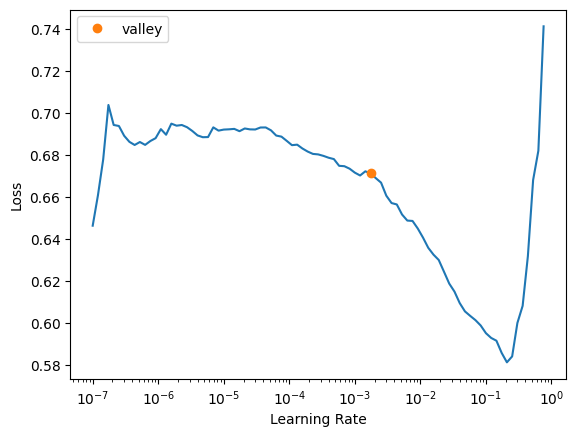

In [3]:
# Tabular data example

path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                'relationship', 'race'],
cont_names = ['age', 'fnlwgt', 'education-num'],
procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

# select the appropriate learning rate
learn.lr_find()

# there's no pretrained model for tabular data that we finetune, so we train from-scratch
# run 3 epochs
learn.fit_one_cycle(3)

# use this to show the model
learn.show_results()

# Now perform prediction:

# Input data with known marital-status and occupation
input_data = pd.DataFrame({'marital-status': ['Married-civ-spouse'], 'occupation': ['Tech-support']})

# Perform prediction on the input data
dl = learn.dls.test_dl(input_data)
preds = learn.get_preds(dl=dl)

# Extract predicted values
predicted_values = preds[0].numpy()[0]

# Convert predicted values to human-readable format
predicted_values = dls.decode_batch((*tuplify(input_data), *tuplify(predicted_values)))[0]

print(predicted_values)


## Hyperparameters

Hyperparameters are parameters that are set prior to the training process and remain constant during training. These parameters control the behavior of the algorithm and influence the performance of the model. Unlike model parameters, which are learned during the training process (such as weights in neural networks), hyperparameters are set by the practitioner or determined through techniques like hyperparameter tuning.

Here are some common hyperparameters in deep learning:

1. Learning Rate: This hyperparameter controls the step size during the optimization process. A higher learning rate can lead to faster convergence but may overshoot the optimal solution, while a lower learning rate may converge slowly.

2. Batch Size: It determines the number of samples that are propagated through the network at once. Larger batch sizes can lead to faster training but require more memory, while smaller batch sizes may lead to slower convergence but can provide a more accurate estimate of the gradient.

3. Number of Epochs: An epoch is one complete pass through the entire training dataset. The number of epochs is a hyperparameter that specifies how many times the learning algorithm will work through the entire training dataset.

4. Network Architecture: Hyperparameters related to the architecture of the neural network, such as the number of layers, the number of neurons in each layer, types of activation functions, etc.

5. Regularization Parameters: Regularization is a technique used to prevent overfitting by adding a penalty term to the loss function. Hyperparameters such as L1 or L2 regularization strength are examples.

6. Dropout Rate: Dropout is a regularization technique where randomly selected neurons are ignored during training. The dropout rate is the probability that a neuron will be dropped out during training.

7. Optimizer Parameters: Hyperparameters related to the optimization algorithm used during training, such as momentum, decay rates, etc.

8. Activation Functions: Hyperparameters related to the choice of activation functions used in the hidden layers of a neural network, such as ReLU, sigmoid, tanh, etc.

Choosing appropriate hyperparameters is crucial for achieving good performance and generalization of the model. Hyperparameter tuning, often done through techniques like grid search or random search, involves experimenting with different combinations of hyperparameters to find the set that yields the best performance on a validation dataset.

# Chapter 2 - Production

To learn how to use DL in production - it's recommended to apply DL to a domain that you know well.  Create a prototype of a system that uses data you have access to.

Some ideas:
* Network intrusion detection - baseline a network, then trigger an alert when network traffic is detected that isn't recognised as a-typical.
* Linux system intrusion detection - baseline a running Linux system, then trigger an alert when the system acts in a way that isn't recognised as a-typical.
* Logs at: https://github.com/logpai/loghub

Both of these could use image-recognition, converting the binary data into an image that represents the data.